

## 3-gene model

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

**1.** Define functions representing the differential equations describing the interactions between species inside a single cell. "dyn" corresponds to dynamic enhancers, "stat" to static ones.


In [2]:
def dyn(conc, param):
    
    x = conc[:,0]
    y = conc[:,1]
    z = conc[:,2]
    
    w = param["w"]
    s = param["s"]
    n = param["n"]
    
    dx = 1./(1.+(y/s)**n) 
    dy = 1./(1.+(z/s)**n) 
    dz = 1./(1.+(x/s)**n)
    
    return np.array([dx, dy, dz]).transpose()



def stat(conc, param):
    
    x = conc[:,0]
    y = conc[:,1]
    z = conc[:,2]
    
    s = param["s"]
    n = param["n"]
        
    dx = 1./(1.+(y/s)**n) /(1.+(z/s)**n)
    dy = 1./(1.+(z/s)**n) /(1.+(x/s)**n)
    dz = 1./(1.+(x/s)**n) /(1.+(y/s)**n)
    
    return np.array([dx, dy, dz]).transpose()





def dconc(g, conc, param):
    
    g = np.array([g for k in range(len(conc[0]))]).transpose()
    
    return g*dyn(conc, param) +(1.-g)*stat(conc, param) -conc

**2.** Define a function representing the spatio-temporal distribution of the parameter g.

In [3]:
def compute_g(t, param):
    
    steepness = param["steepness"]
    elongation_speed = param["elongation_speed"]
    
    g = np.exp(steepness*(ap_positions*n_cells -elongation_speed*t))
    g[g > 1.] = 1.
    
    return g

**3.** Define a function that performs the integration using the Euler method.

In [4]:
def integrate(init_conc, time_param, ode_param):

    init_t = time_param["init_t"]
    total_t = time_param["total_t"]
    dt = time_param["dt"]
    times = np.arange(init_t, init_t+total_t, dt)
   
    counter = 0
    n_skr = time_param["n_skr"]  # number of Steps modulo which you want to Keep the Results
    
    typ_conc = ode_param["typ_conc"]

    conc = init_conc
    results = [conc]
    g_gradient = [compute_g(init_t, ode_param)]
    times_plot = [init_t]
    
    
    for t in times[1:]:
    
        g = compute_g(t, ode_param)
        
        conc = conc +dconc(g, conc, ode_param)*dt 
        conc[conc < 0.] = 0.
        
    
        counter += 1
        if (counter %n_skr == 0):
            results.append(conc)
            g_gradient.append(g)
            times_plot.append(t)
        

    results = np.array(results)
    g_gradient = np.array(g_gradient)
    times_plot = np.array(times_plot)
    
    return results, g_gradient, times_plot

**5.** Define three functions to visualise the results:

- a function that plots the kymographs of the concentration of the 3 genes and the morphogen
- a function that plots the kymograph of the concentration of one specified gene
- a function that plots the time evolution of the concentration of the 3 genes and the morpoghen in a single cell

In [5]:
def plot_all_kymographs(results, g_gradient):
    
    fig, ax = plt.subplots(2,2)
    
    # Plot kymographs for the different species
    for genes_index in range(len(results[0,0])):
        
        i = int((genes_index)/2)  # Row index in the plot grid
        j = genes_index%2         # Column index in the plot grid
        
        ax[i,j].axis('off')

        norm = colors.Normalize(vmin=0.0, vmax=1.0)   
        graph = ax[i,j].imshow(results[:,:,genes_index].transpose(), norm=norm, origin='lower', interpolation='bilinear', aspect='auto')
    
        colorbar = fig.colorbar(graph, ticks=[1.0,0.5,0.0], ax=ax[i,j])
        colorbar.ax.tick_params(labelsize=8)
        ax[i,j].set_title(genes_names[genes_index], fontsize=10)
    
    
    # Plot a kymograph for the morphogen gradient
    ax[1,1].axis('off')

    norm = colors.Normalize(vmin=0.0, vmax=1.0)
    graph = ax[1,1].imshow(g_gradient.transpose(), norm=norm, origin='lower', interpolation='bilinear', aspect='auto')

    colorbar = fig.colorbar(graph, ticks=[1.0,0.5,0.0], ax=ax[1,1])
    colorbar.ax.tick_params(labelsize=8)
    ax[1,1].set_title('g', fontsize=10)
    
    fig.savefig('Kymos_3genes.png', dpi=300)
    
    
    
def plot_single_kymograph(results, gene_index):
    
    fig, ax = plt.subplots()

    norm = colors.Normalize(vmin=0.0, vmax=1.0)
    kymo = ax.imshow(results[:,:,gene_index].transpose(), norm=norm, origin='lower', interpolation='bilinear', aspect='auto')

    frame = plt.gca()                      # Remove axis (i.e. ticks and spines)
    frame.axes.get_xaxis().set_ticks([])
    frame.axes.get_yaxis().set_ticks([])
    frame.axes.spines['left'].set_visible(False)
    frame.axes.spines['right'].set_visible(False)
    frame.axes.spines['top'].set_visible(False)
    frame.axes.spines['bottom'].set_visible(False)

    ax.set_xlabel('Time', fontsize=14)
    ax.set_ylabel('Position', fontsize=14)

    cb = fig.colorbar(kymo, ax=ax, shrink=0.75)
    cb.ax.tick_params(labelsize=10)

    fig.savefig('Kymo_'+genes_names[gene_index]+'.png', dpi=300)
    
    
def plot_time_course(results, g_gradient, times, cell_position):
    
    fig, ax = plt.subplots()
    
    ax.plot(times, g_gradient[:, cell_position], color='tab:gray', label='g')
    for gene_index in range(len(results[0,0])):
        ax.plot(times, results[:,cell_position,gene_index], genes_colors[gene_index], label=genes_names[gene_index])
        
    ax.set_xlabel('Time')
    ax.set_ylabel('Concentration')
    ax.legend()
    
    fig.savefig('Conc_time_course_3genes.pdf')

**6.** Generate a line of cells representing the tissue undergoing a patterning process. Provide the initial concentrations for each gene in each cell. Perform the integration and plot the desired kymographs. WE visualize the time-course in two cells stabilizing in different fates.

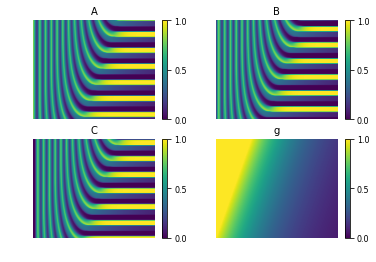

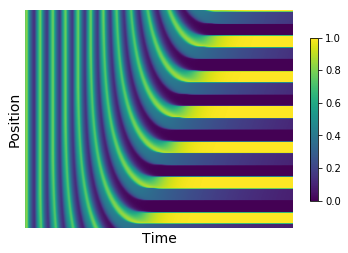

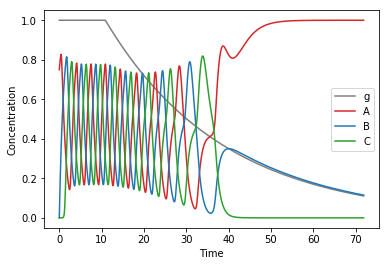

In [6]:
time_param = {
    "init_t" : 0.,
    "total_t" : 72.,
    "dt" : 0.01,
    "n_skr" : 10  # number of Steps modulo which you want to Keep the Results
}

ode_param = {
    "typ_conc" : 1000.,
    "steepness" : 0.003,
    "elongation_speed" : 12.,
    "w" : 2.5,
    "s" : 0.4,
    "n" : 10
}


n_cells = 250
ap_positions = np.linspace(0.0, 1.0, n_cells)

genes_names = ['A', 'B', 'C']
genes_colors = ['tab:red', 'tab:blue', 'tab:green']

init_conc = np.zeros((n_cells, 3))
init_conc[:,0] = 0.75    # Initial conditions


results, g_gradient, times_plot = integrate(init_conc, time_param, ode_param)

plot_all_kymographs(results, g_gradient)
plot_single_kymograph(results, 0)
plot_time_course(results, g_gradient, times_plot, int(n_cells/2.))
plot_time_course(results, g_gradient, times_plot, int(n_cells/2.)+5)